# 1. Setup

Megkérjük a Google Colabot, hogy dedikáljon számunkra egy videókártyát, ehhez az szükségünk van arra, hogy átállítsuk a GPU-ra a használatot. Runtime menüpont --> Change Runtime Type --> T4 GPU kiválasztása

In [ ]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


Klónozzuk a repónkat és csatlakozunk a Google Drive-hoz

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive', force_remount=True) #force_remount -> erőszakosan újracsatlakozunk a drivehoz

Mounted at /content/gdrive


Definiáljuk azt a mappát melyben dolgozni fogunk, ahová a könyvtárakat fogjuk letölteni és ahol az ideiglenes fájlokat fogjuk tárolni

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/') #definiáljuk a mappát melybe az ideiglenes fájlokat fogjuk tárolni
root_dir = "/content/gdrive/MyDrive/YOLO/" #létrehozunk egy változót ahol a Dataset található a tanításhoz

Megnézzük, hogy létezik-e már a yolo mappánk és ha igen akkor töröljük

In [ ]:
!rm -rf '/content/yolov5'
print("Remove complete.")

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Remove complete.


Yolo-t telepítjük a súlymodellek alkalmazásához (A legfrissebb verziókhoz, közvetlenül a gitről szedjük le)

In [ ]:
!git clone https://github.com/ultralytics/yolov5 #A Github-ról letöltjük (klónozzuk a Yolo5 adatait)
#%cd yolov5 #Belépünk a yolov5 mappába, hogy tudjunk benne dolgozni
%cd '/content/yolov5'

%pip install -qr requirements.txt #telepítjük az összes függőséget

Cloning into 'yolov5'...
remote: Enumerating objects: 16008, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 16008 (delta 22), reused 21 (delta 13), pack-reused 15967
Receiving objects: 100% (16008/16008), 14.60 MiB | 14.96 MiB/s, done.
Resolving deltas: 100% (10988/10988), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


Importáljuk a torch-ot

In [ ]:
import torch
from IPython.display import Image, clear_output

#clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
#A tréning megkezdése előtt, ellenőrizzük mindig, hogy a mire kívánja a rendszer a tanítást küldeni, amennyiben CPU jelenik meg,
# futtassuk újra torch.cuda.get_device_name(0)

Setup complete. Using torch 2.1.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


A tréning megkezdéséhez kezdjük a felparaméterezést, ehhez beolvassuk a yaml fájl-t

In [ ]:
%cat '/content/gdrive/MyDrive/YOLO/data.yaml'

train: /content/gdrive/MyDrive/YOLO/training/images/
val: /content/gdrive/MyDrive/YOLO/validation/images/
test: /content/gdrive/MyDrive/YOLO/test/images/

nc: 2
names: ['no-mask', 'mask']

Kiolvassuk az osztályokat a yaml fájlból, és regisztráljuk őket a tanításhoz

In [ ]:
import yaml
with open('/content/gdrive/MyDrive/YOLO/data.yaml', 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

# 2. Train

Wandb telepítése, ahhoz, hogy működjön authentikációt fog kérni

In [ ]:
# Súlyok
%pip install -q wandb
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Következik a Yolo tréning


In [ ]:
#Definiáljuk az idő változót, hogy lássuk mennyi idő alatt teljesítette a tanulást
%%time
#Megkezdődjük a tréninget 200 epochon
!python /content/yolov5/train.py --img-size 640 --batch-size 80 --epoch 100 --data /content/gdrive/MyDrive/YOLO/data.yaml --weight yolov5s.pt --cache
# img-size : a tréninghez használt képek felbontása
# batch-size : az egyszerre tanításra beküldött bathek száma
# epoch : a tréning hányszor fusson le, melyből majd a legjobb eredményt fogjuk kiválasztani
# (két eredmény lesz, legjobb teljesítményű és a legnagyobb pontosságú)
# weight súlymodell megadása az előzőleg kiszámoltak alapján (yolov5s.pt)
#(PPT-ben van, hogy a kamera, a mérési biztonság és a feldolgozási idő alapján melyiket fogjuk használni)
!cp -R '/content/yolov5/runs' '/content/gdrive/MyDrive/YOLODATA/'

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: gaotu. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/content/gdrive/MyDrive/YOLO/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=80, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CUDA

# 3. Test: Run detection on images

In [ ]:
!python /content/yolov5/detect.py --weights /content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.pt --img 640 --conf 0.4 --source /content/gdrive/MyDrive/YOLO/test/images
# conf : 0.4 // Objektum megbízhatósági-küszöbérték

detect: weights=['/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.pt'], source=/content/gdrive/MyDrive/YOLO/test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/306 /content/gdrive/MyDrive/YOLO/test/images/image_2805.jpg: 640x640 13 no-masks, 3 masks, 11.6ms
image 2/306 /content/gdrive/MyDrive/YOLO/test/images/image_2806.jpg: 640x640 4 masks, 11.6ms
image 3/306 /content/gdrive/MyDrive/YOLO/test/images/image_2807

Az eredmények után helyezzük rá a képekre a kereteket

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg'):
  display(Image(filename=imageName))
  print("\n")

Átmásoljuk a detect eredményeit a YOLODATA könytárba is

In [ ]:
!cp -R '/content/yolov5/runs' '/content/gdrive/MyDrive/YOLODATA/'

# 4. Convert PT to ONNX

Létrehozzuk az ONNX fájlunkat, ehhez szükségünk lesz arra a best.pt fájlra, melyet a legjobbnak itáltünk (ext mappa) - ahol a max epochs ment

In [ ]:
#!pip install -U coremltools onnx scikit-learn # installáljuk a szükséges könyvtárat
!python /content/yolov5/export.py --weights /content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.pt --include torchscript onnx # konvertálás onnx fájlra

export: data=yolov5/data/coco128.yaml, weights=['/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.pt with output shape (1, 25200, 7) (13.8 MB)

TorchScript: starting export with torch 2.1.0+cu118...
TorchScript: export success ✅ 3.7s, saved as /content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.14.1...
ONNX: export success ✅ 1.1s, saved as /content/gdrive/MyDr

Teszteljük a létrejött onnx fájlunkat

In [ ]:
!python /content/yolov5/detect.py --weights /content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.onnx --img 640 --conf 0.4 --source /content/gdrive/MyDrive/YOLO/test/images/ --save-crop

detect: weights=['/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.onnx'], source=/content/gdrive/MyDrive/YOLO/test/images/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-227-ge4df1ec Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Loading /content/gdrive/MyDrive/YOLODATA/runs/train/exp3/weights/best.onnx for ONNX Runtime inference...
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 MB 259.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 207.1 MB

# 5. Local logging

Metadata

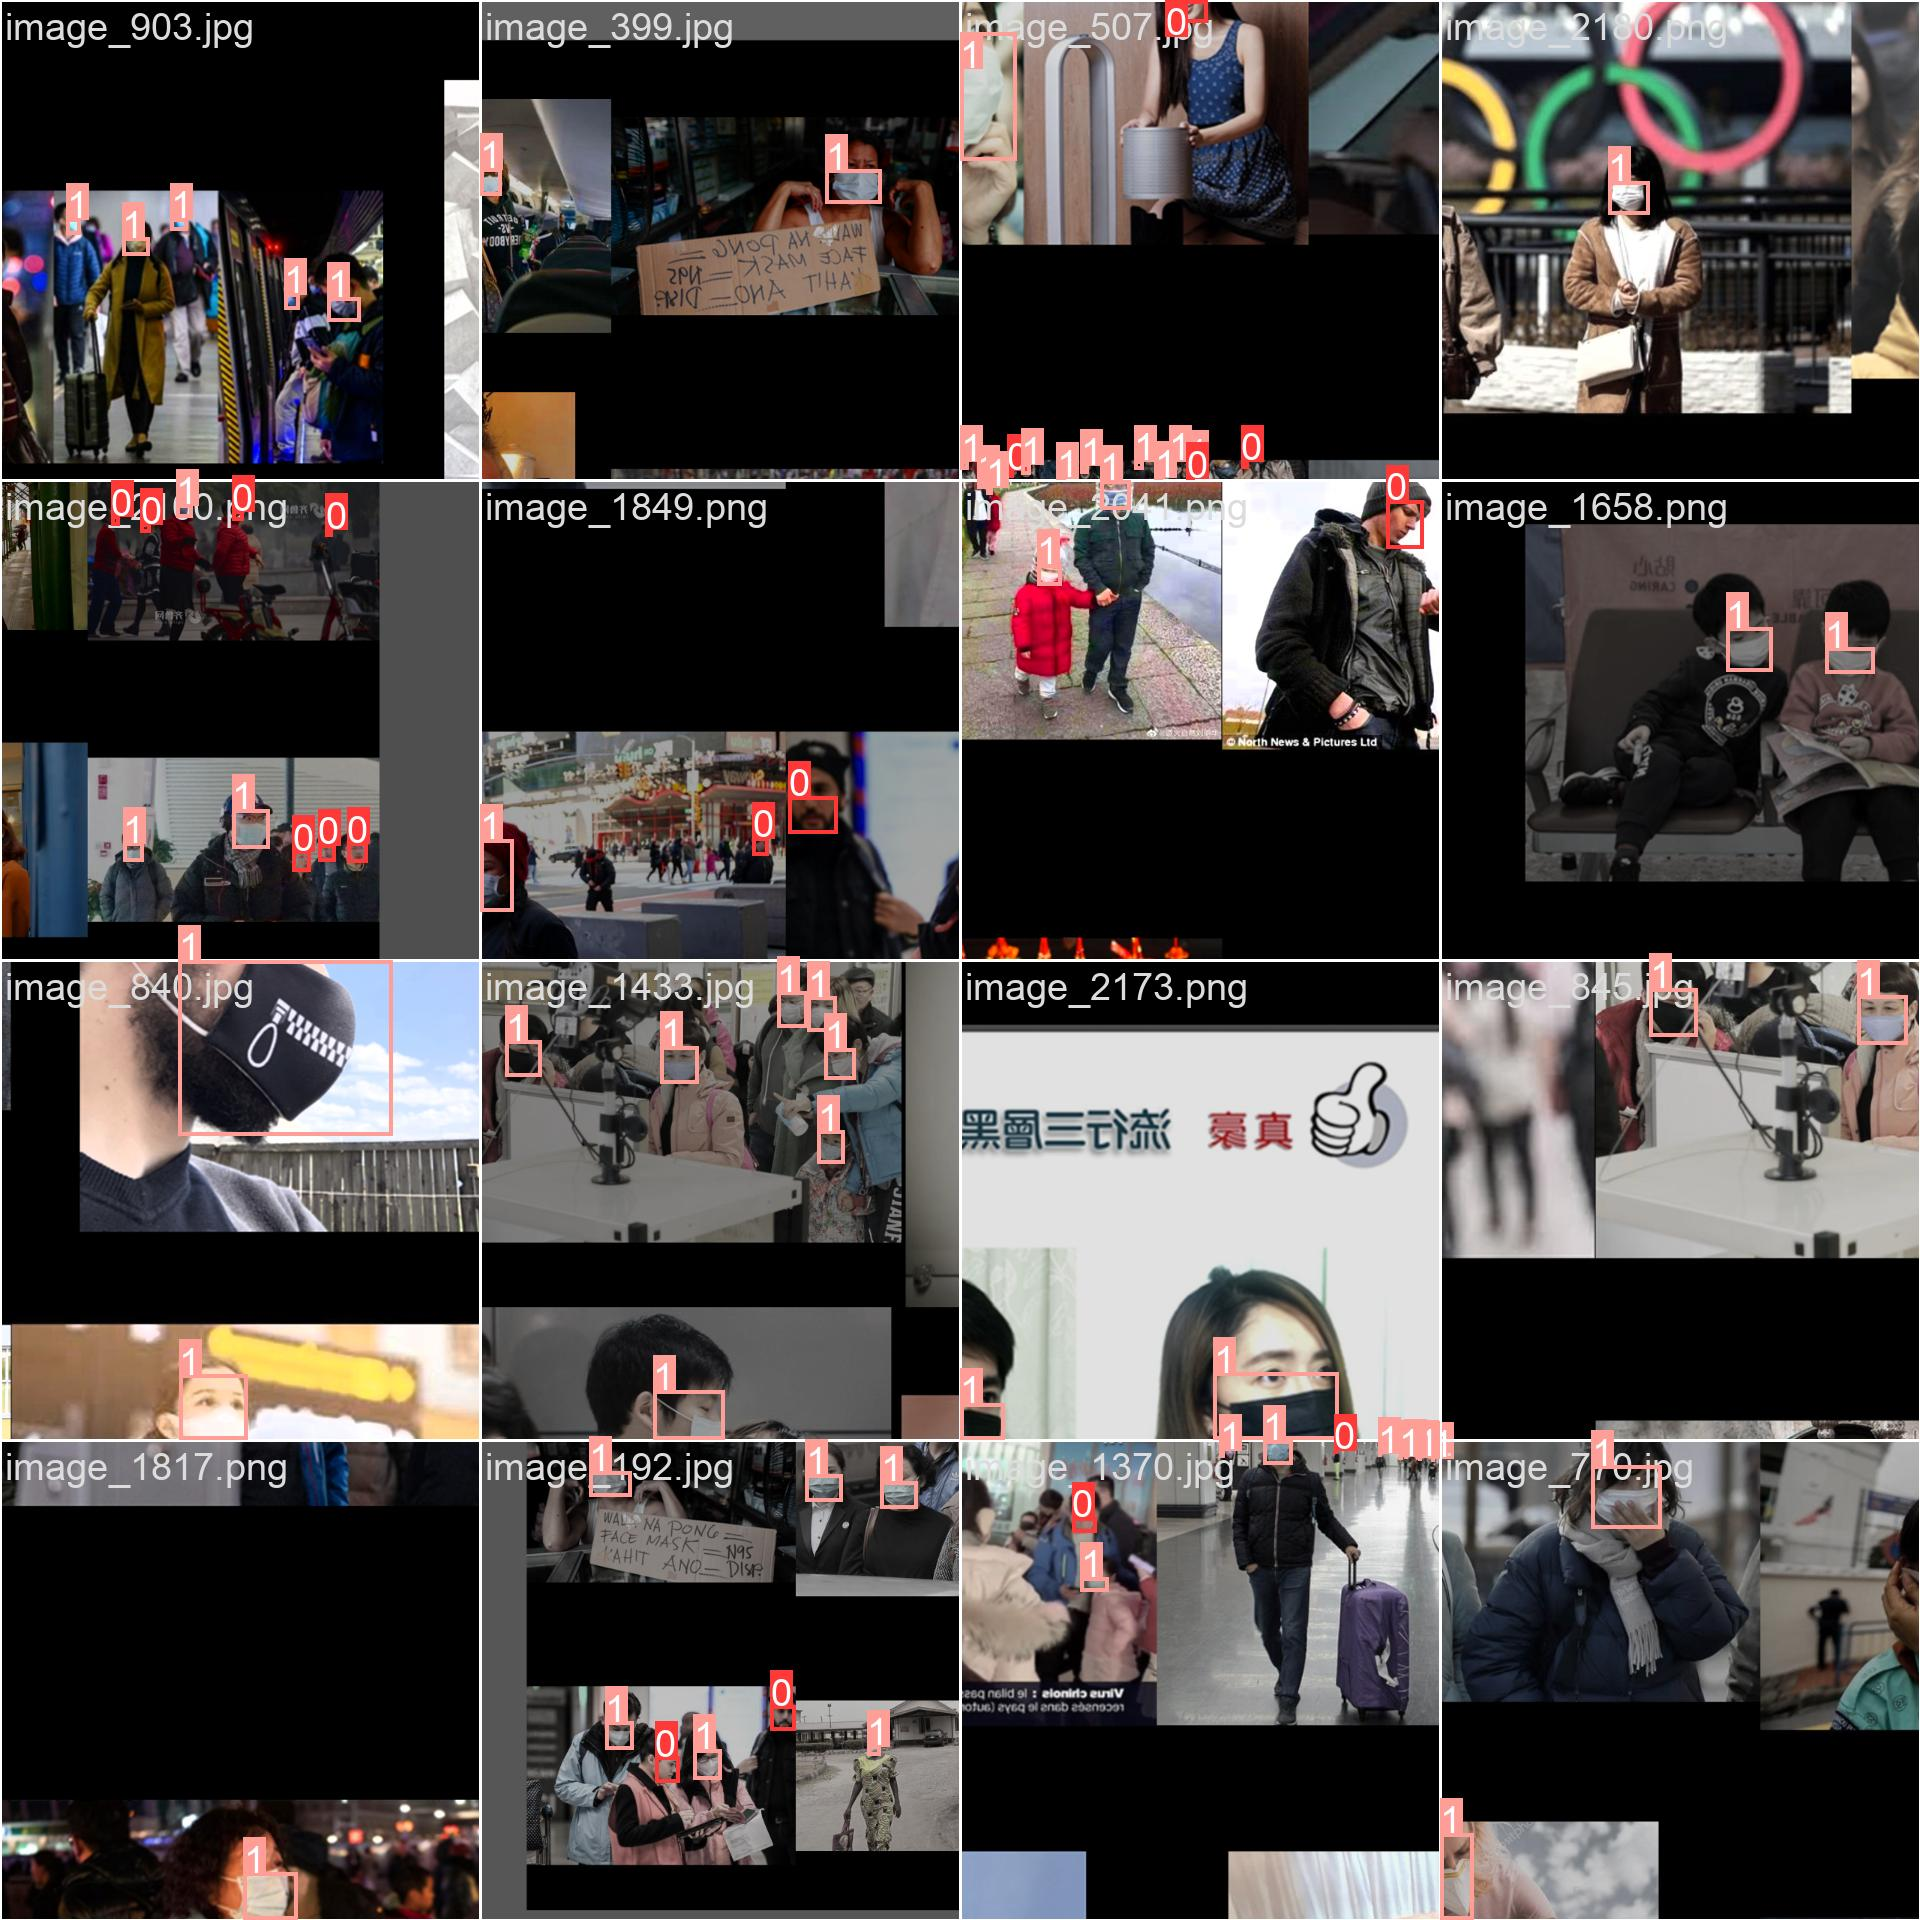

In [ ]:
Image(filename='/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/train_batch0.jpg', width=800) # train batch 0 mosaics and labels
Image(filename='/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/train_batch1.jpg', width=800) # train batch 0 labels
Image(filename='/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/train_batch2.jpg', width=800) # train batch 0 predictions

Result

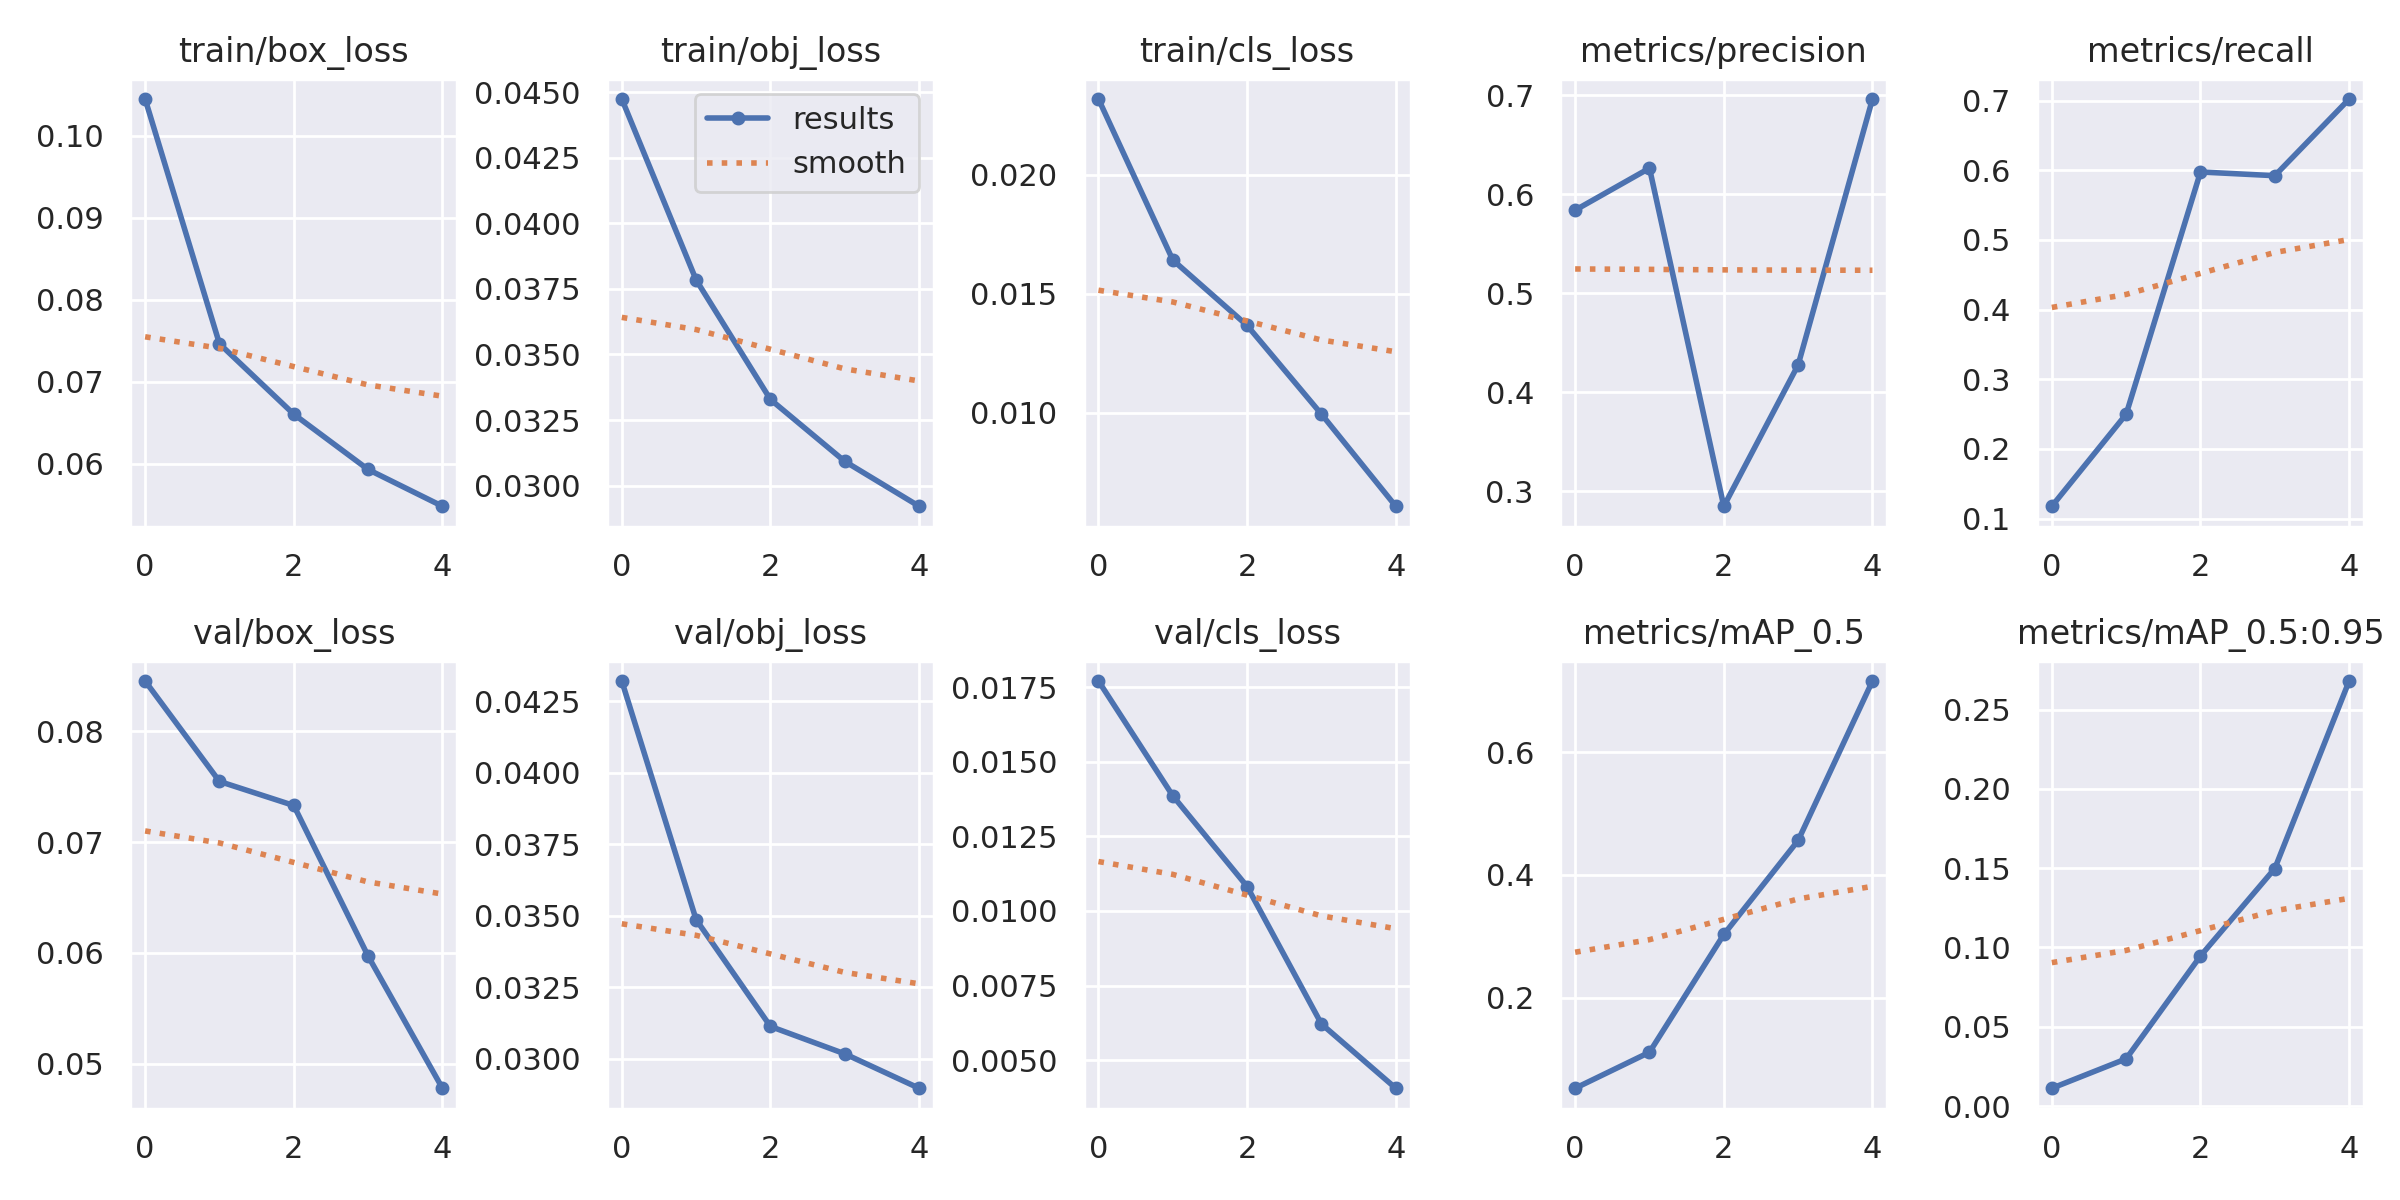

In [ ]:
Image(filename='/content/gdrive/MyDrive/YOLODATA/runs/train/exp3/results.png', width=800) # train batch 0 predictions